# Escaping particles

Sometimes we are not interested in particles that get too far from the central body.  Here we will define a radius beyond which we remove particles from the simulation.  Let's set up an artificial situation with 3 planets, and the inner one moves radially outward with $v > v_{escape}$.

In [1]:
import rebound
import numpy as np
def setupSimulation():
    sim = rebound.Simulation()
    sim.add(m=1., hash="Sun")
    sim.add(x=0.4,vx=5., hash="Mercury")
    sim.add(a=0.7, hash="Venus")
    sim.add(a=1., hash="Earth")
    sim.move_to_com()
    return sim

sim = setupSimulation()
sim.status()

---------------------------------
REBOUND version:     	2.19.1
REBOUND built on:    	Jul  8 2016 19:40:49
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.000000
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.0 x=0.4 y=0.0 z=0.0 vx=5.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.0 x=0.7 y=0.0 z=0.0 vx=0.0 vy=1.1952286093343936 vz=0.0>
<rebound.Particle object, m=0.0 x=1.0 y=0.0 z=0.0 vx=0.0 vy=1.0 vz=0.0>
---------------------------------


Now let's run a simulation for 20 years (in default units where $G=1$, and thus AU, yr/2$\pi$, and $M_\odot$, see [Units.ipynb](../Units) for how to change units), and set up a 50 AU sphere beyond which we remove particles from the simulation.  We can do this by setting the `exit_max_distance` flag of the simulation object.  If a particle's distance (from the origin of whatever inertial reference frame chosen) exceeds `sim.exit_max_distance`, an exception is thrown.

If we simply call `sim.integrate()`, the program will crash due to the unhandled exception when the particle escapes, so we'll create a `try`-`except` block to catch the exception.  We'll also store the x,y positions of Venus, which we expect to survive.

In [2]:
sim = setupSimulation() # Resets everything
sim.exit_max_distance = 50.
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xvenus, yvenus = np.zeros(Noutputs), np.zeros(Noutputs)
for i,time in enumerate(times):
    try:
        sim.integrate(time)  
    except rebound.Escape as error:
        print(error)
        for j in range(sim.N):
            p = sim.particles[j]
            d2 = p.x*p.x + p.y*p.y + p.z*p.z
            if d2>sim.exit_max_distance**2:
                index=j # cache index rather than remove here since our loop would go beyond end of particles array
        sim.remove(index=index)
    xvenus[i] = sim.particles[2].x
    yvenus[i] = sim.particles[2].y

A particle escaped (r>exit_max_distance).


In [3]:
print("Went down to {0} particles".format(sim.N))

Went down to 3 particles


So this worked as expected.  Now let's plot what we got:

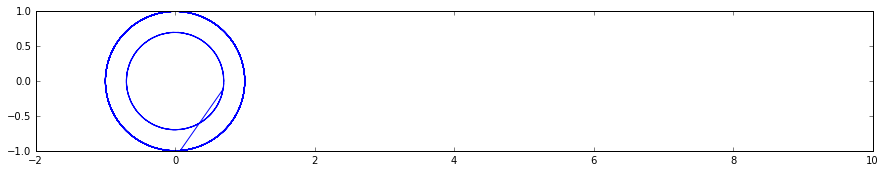

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(xvenus, yvenus)
ax.set_aspect('equal')
ax.set_xlim([-2,10]);

This doesn't look right.  The problem here is that when we removed `particles[1]` from the simulation, all the particles got shifted down in the `particles` array.  So following the removal, `xvenus` all of a sudden started getting populated by the values for Earth (the new `sim.particles[2]`).  A more robust way to access particles is using hashes (see [UniquelyIdentifyingParticlesWithHashes.ipynb](../UniquelyIdentifyingParticlesWithHashes))

A particle escaped (r>exit_max_distance).


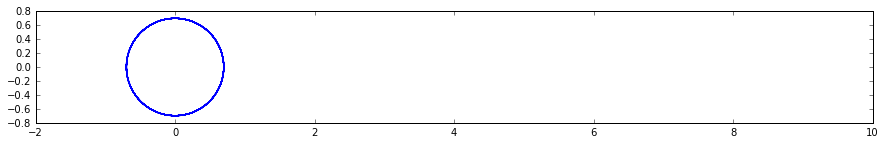

In [5]:
sim = setupSimulation() # Resets everything
sim.exit_max_distance = 50.
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xvenus, yvenus = np.zeros(Noutputs), np.zeros(Noutputs)
for i,time in enumerate(times):
    try:
        sim.integrate(time)  
    except rebound.Escape as error:
        print(error)
        for j in range(sim.N):
            p = sim.particles[j]
            d2 = p.x*p.x + p.y*p.y + p.z*p.z
            if d2>sim.exit_max_distance**2:
                index=j # cache index rather than remove here since our loop would go beyond end of particles array
        sim.remove(index=index)
    xvenus[i] = sim.particles["Venus"].x
    yvenus[i] = sim.particles["Venus"].y

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(xvenus, yvenus)
ax.set_aspect('equal')
ax.set_xlim([-2,10]);

Much better!  We solved the problem by assigning particles hashes and using those to access the particles for output.